In [137]:
import time
import graphviz
import numpy as np

In [138]:
import pyro
import pyro.distributions as dist
import pyro.infer.autoguide as auto
import pyro.optim as optim
import pyro.poutine as poutine
import sympy as sym
import torch
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate

In [167]:
D = 4 # dimensionality of genome and transcriptome (number of genes) 
N = 2 # number of tumors or subjects 
M = 2 # number of single-cell observations per tumor 
T = 2 # time (number of generations) after which tumor is sampled
fl = 0.1 # observational noise model (flip probability)
ep = 1 # variance of all Gaussian random variables

In [242]:
@config_enumerate
def model(data):

    theta_h = pyro.sample(
        "th_h", dist.Normal(torch.zeros(D, D), torch.ones(D, D)).to_event(2)
    )
    theta_z0 = pyro.sample(
        "th_z0", dist.Uniform(torch.zeros(1, D), torch.ones(1, D)).to_event(2)
    )

    count = 0
    for i in pyro.plate('plate1', N):

        z0 = pyro.sample(
            "z0_{}".format(i), dist.Normal(theta_z0, ep * torch.ones(1, D)).to_event(2)
        )
        z0 = 1 / (1 + torch.exp(-z0))

        while 1:
            count = count + 1
            ls = r_nest_list(z0, theta_h, 2**count, 1, T)
            xs = extract_level(ls, torch.tensor([0,0,0,0]), T)
            samp = []
            if len(xs.size()) > 1:
                break
                
        for j in pyro.plate("plate3_{}".format(i), M):
        #with pyro.plate("plate3_{}".format(i), M):
            idx = pyro.sample(
                "samp_{}_{}".format(i, j),
                #"samp_{}".format(i),
                dist.Categorical(torch.ones(xs.size()[1]-1))
            )
            
            pyro.sample(
                "obs_{}_{}".format(i, j),
                #"obs_{}".format(i),
                dist.Bernoulli(
                    (1 - (2*fl)) * (xs[:,idx+1]) + fl
                ).to_event(1),
                obs=data[i][j]
                #obs=data[i]          
            )   
            
            

In [243]:
def generate_data():

    theta_h = pyro.sample(
        "th_h", dist.Normal(torch.zeros(D, D), torch.ones(D, D)).to_event(2)
    )
    theta_z0 = pyro.sample(
        "th_z0", dist.Normal(torch.zeros(1, D), torch.ones(1, D)).to_event(2)
    )

    data = []
    count = 0
    for i in range(0, N):

        z0 = pyro.sample(
            "z0_{}".format(i), dist.Normal(theta_z0, ep * torch.ones(1, D)).to_event(2)
        )
        z0 = 1 / (1 + torch.exp(-z0))

        while 1:
            count = count + 1
            ls = r_nest_list(z0, theta_h, 2**(count), 1, T)
            xs = extract_level(ls, torch.tensor([0,0,0,0]), T)
            samp = []
            print(xs.size())
            if len(xs.size()) > 1:
                break
            
        dat = []    
        for j in range(0, M):
            idx = pyro.sample(
                "samp_{}_{}".format(i, j),
                dist.Categorical(torch.ones(xs.size()[1]-1))
            )    
            
            d = pyro.sample(
                "obs_{}_{}".format(i, j),
                dist.Bernoulli(
                    (1 - (2*fl)) * (xs[:,idx+1]) + fl
                ).to_event(1)
            )
            
            dat.append(d)

        data.append(dat)

    return data, theta_h, theta_z0

In [244]:
def f(z, theta):
    vec = torch.matmul(z, theta)
    return (1*(vec**2))


def g(x, theta):
    vec = torch.matmul(x, theta)
    return vec


def h(z, theta):
    vec = torch.matmul(z, theta)
    return vec

In [258]:
def r_nest_list(z, theta_h, step, level, maxL):

    w = pyro.sample("w_{}".format(step), dist.Exponential(2))
    if level == maxL:
        w = torch.tensor(0.0)
    #else:
    #    w = pyro.sample("w_{}".format(step), dist.Exponential(f(z, theta_f)))
    w1 = torch.round(w)
    ls = [((level, step, w1), z)]

    if (w1>0):
        for ii in pyro.plate("node_{}".format(step), int(w1)):
            z1 = pyro.sample(
                "z1_{}_{}".format(step, ii),
                dist.Normal(h(z, theta_h), ep * torch.ones(1, D)).to_event(2),
            )
            z1 = 1 / (1 + torch.exp(-z1))
            ls.append(
                r_nest_list(
                    z1,
                    theta_h,
                    step * (sym.prime(level + 1) ** (ii + 1)),
                    level + 1,
                    maxL,
                )
            )

    return ls

In [259]:
def extract_level(ls, xs, L):
    lbl = ls[0]
    c_level = lbl[0][0]
    w = lbl[0][2]
    if c_level == L:
        if len(xs.size()) > 1:
            xs = torch.cat((xs,lbl[1][0].view(4, 1)),dim=1)
        else:        
            xs = torch.stack((xs,lbl[1][0]),dim=1)      
        #xs.append(lbl[1][0])
    for ii in range(0, int(w)):
        xs = extract_level(ls[ii + 1], xs, L)
    return xs

In [260]:
torch.manual_seed(10)
data, theta_f0, theta_z00 = generate_data()
auto_guide = auto.AutoDelta(
    poutine.block(
        model,
        hide=[
            "samp_0_0",
            "samp_0_1",
            "samp_0_2",
            "samp_0_3",
            "obs_0_0",
            "obs_0_1",
            "obs_0_2",
            "obs_0_3",
            "samp_1_0",
            "samp_1_1",
            "samp_1_2",
            "samp_1_3",
            "obs_1_0",
            "obs_1_1",
            "obs_1_2",
            "obs_1_3",
            "samp_2_0",
            "samp_2_1",
            "samp_2_2",
            "samp_2_3",
            "obs_2_0",
            "obs_2_1",
            "obs_2_2",
            "obs_2_3",
        ],
    )
)

torch.Size([4])
torch.Size([4, 2])
torch.Size([4, 2])


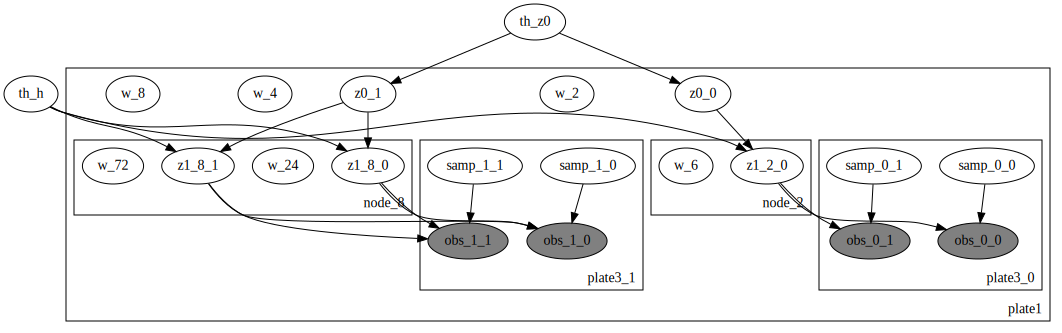

In [262]:
pyro.render_model(
    model, model_args=(data,), render_params=True, render_distributions=False, filename="model_out.pdf"
)

In [ ]:
elbo = TraceEnum_ELBO()
elbo.loss(model, config_enumerate(auto_guide, "sequential"), data)

pyro.clear_param_store()
svi = SVI(
    model=model, guide=auto_guide, optim=optim.ClippedAdam({"lr": 0.001}), loss=elbo
)

# Optimize
print("Optimizing...")
start_time = time.time()
optimization_steps = 10
for i in range(optimization_steps):

    loss = svi.step(data)
    print(f"iter: {i}, loss: {round(loss,2)}", end="\n")

print()

out = auto_guide.median()